In [ ]:
import pandas as pd
from helpers import config
import plotly.express as px
from helpers.preprocessing import *
from helpers import config
from helpers.plots import save_plot
%load_ext autoreload
%autoreload 2

In [ ]:
dataset = "transatlantic"
signal = config[dataset]["signal"]
print(f"working on signal : {dataset}/{signal}")

# Helper functions

In [ ]:
def get_pair(df,m1,m2):
    return df[(df.market1==m1) * (df.market2==m2)]

def keep_positive(x):
    """return the data for which lags are positive ON AVERAGE"""
    to_keep = x[["lag","pair"]].groupby("pair").mean()>0#.set_index("pair")
    to_keep = to_keep.rename(columns={"lag":"lag+"})
    x = x.set_index("pair").join(to_keep,how="inner").reset_index()
    return x[x["lag+"]]

def remove_lag_outliers(df,confidence=0.99,replace=None):
    quantile = df["lag"].abs().quantile(q=confidence)
    if replace!=None:
        df[df.lag.abs() > quantile]["lag"] = replace
        return df
    return df[df.lag.abs() <= quantile]

def add_pair_names(df):
    df["pair"] = df["market1"]+"_"+df["market2"]
    return df

def add_distances(df):
    df["distance"] = df[["market1","market2"]].apply(lambda x : get_distance(x.market1,x.market2) ,axis=1)
    return df

def absolute_lag(df):
    df["lag"] = df["lag"].abs()
    return df

def pipeline(df,transforms):
    for t in transforms:
        df = t(df)
    return df

def pair_wise_moving_average(df,rolling_window,col="lag",id_col="pair"):
    """the moving average needs to be compute separately on each market pair"""
    res = df.copy().set_index(id_col)
    ids = res.index.unique()
    for id_ in ids:
        res.loc[id_,col] = moving_average(res.loc[id_,col],w=rolling_window)
    return res.reset_index() 

## Loading data

In [ ]:
lags_ret = pd.read_csv(config["files"]["results"][signal]["all_best_lags"].format("_".join(["numeric","log_returns"])))
#lags_price = pd.read_csv(config["files"]["results"][signal]["all_best_lags"].format("_".join(["numeric"])))

In [ ]:
mean_returns = pd.read_csv(config["files"]["results"][signal]["mean_trade_returns"].format("_".join(["US",signal])))
mean_prices  = pd.read_csv(config["files"]["results"][signal]["mean_trade_prices"].format("_".join(["US",signal])))

In [ ]:
def plot_mean_prices():
    fig = px.line(mean_prices, x="date", y="price",title=f"Shell stock price evolution",log_y=False)
    save_plot(fig,name=f"daily_mean_prices_{signal}")
    fig.show()
    
def plot_mean_returns():
    fig = px.line(mean_prices, x="date", y="price",title=f"Shell returns evolution",log_y=False)
    save_plot(fig,name=f"mean_returns_{signal}")
    fig.show()

# Plotting lags

In [ ]:
def plot_pair_lags(df,m1,m2):
    fig = px.line(get_pair(best_lags,m1,m2), x="date", y="lag", title=f"lags vs date between {m1}/{m2}")
    fig.show()

def plot_all_pairs(df,rolling_window=1,take_abs = True):
    
    p = [add_pair_names,keep_positive,remove_lag_outliers]
    if take_abs:
        p+=[absolute_lag]
    to_plot = pipeline(df,p)
    # rolling average
    to_plot = pair_wise_moving_average(to_plot,rolling_window)
    
    fig = px.line(to_plot, x="date", y="lag",color="pair", title=f"lags vs date (all pairs), MA={rolling_window} days",log_y=False)
    fig_title = f"lags_{signal}_{rolling_window}"
    if take_abs:
        fig_title = f"absolute_lags_{signal}_{rolling_window}" 
    save_plot(fig,name=fig_title)
    fig.show()

In [ ]:
plot_all_pairs(lags_ret,60,False)

In [ ]:
plot_mean_prices()

https://www.24heures.ch/economie/benefice-net-shell-divise-huit-2015/story/29746011
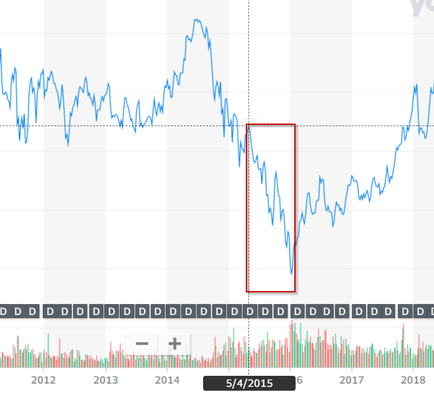

# Lags vs distance

## visualization

In [ ]:
def get_distance(a,b):
    return config[dataset]["distances"][a][b]

def format_date(date):
    return date.replace("-","_")
def plot_mean_lag_vs_distance(lags_data,date1,date2):
    mean_lags = []
    distances = []
    pairs = []
    for m1 in config[dataset]["markets"]["list"]:
        for m2 in config[dataset]["markets"]["list"]:
            if m1>m2:
                locality_data = get_pair(lags_data,m1,m2)
                locality_data = locality_data[(locality_data["date"]>=date1)*(locality_data["date"]<=date2)]
                mean_lag      = locality_data.lag.abs().mean()
                distance = get_distance(m1,m2)

                mean_lags.append(mean_lag)
                distances.append(distance)
                pairs.append(f"{m1}_{m2}")
    to_plot = pd.DataFrame({"distance": distances,"mean_lag":mean_lags,"pair":pairs})

    fig = px.scatter(to_plot, x=f"distance", y="mean_lag",trendline="ols",hover_data=["pair"]) 
    title=f"mean lag vs distance ({signal} from {date1} to {date2})"
    save_plot(fig,name=f"mean_lag_vs_distance_{format_date(date1)}_{format_date(date2)}")
    fig.update_layout(
    title=title,
    xaxis_title="distance(km)",
    yaxis_title="mean lag(ms)")  
    fig.show()

In [ ]:
date1,date2 = "2005-00-01","2017-12-31"
plot_mean_lag_vs_distance(lags_ret,date1,date2)

In [ ]:
date1,date2 = "2009-06-00","2009-08-00"
plot_mean_lag_vs_distance(lags_ret,date1,date2)

In [ ]:
def plot_lags_vs_distance(lags_data):
    to_plot = pipeline(lags_data,[add_pair_names,keep_positive,absolute_lag,add_distances,remove_lag_outliers])
    title = ""
    fig = px.scatter(to_plot, x=f"distance", y="lag",color="pair") 
    title=f"lags vs distances ({signal})"
    save_plot(fig,name=title)
    fig.update_layout(
        title=title,
        xaxis_title="distance(km)",
        yaxis_title="lag(ms)")  
    fig.show()


In [ ]:
plot_lags_vs_distance(lags_ret)

## rolling regression

In [ ]:
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tools.tools import add_constant

In [ ]:
def rolling_ols(lags_data,window=100):
    regression_data = pipeline(lags_data,[add_pair_names,keep_positive,absolute_lag,add_distances])
   
    regression_data = remove_lag_outliers(regression_data,confidence=0.95)
    regression_data = regression_data.sort_values(["date","market1","market2"]).set_index("date")
    regression_data = add_constant(regression_data)
    
    mod = RollingOLS(regression_data["lag"], regression_data[["distance","const"]],
                     window=3*window) # we have 3 data points per day
    rolling_res = mod.fit()
    params = rolling_res.params.dropna().reset_index().rename(columns={"distance":"beta","const":"alpha"})
    
    title='evolution_of_beta_parameter'
    fig = px.line(params, x="date", y="beta", title=title)
    save_plot(fig,name=title)
    fig.show()

In [ ]:
rolling_ols(lags_ret,60)

# Lag vs Liquidity

In [ ]:
# loading liquidity data
liquidity_data = pd.read_csv(config["files"]["results"][signal]["liquidity"])
liquidity_data.head(2)

In [ ]:
def plot_liquidity(liquidity_data,rolling_window):
    to_plot = liquidity_data.copy()
    to_plot = pair_wise_moving_average(to_plot,rolling_window,col="period",id_col="market")
    title=f"Evolution of the daily median of elapsed period between {signal}"
    fig = px.line(to_plot, x="date", y="period",color="market",title=title,log_y=False)
    save_plot(fig,name="liquidity evolution",)
    fig.update_layout(
    yaxis_title="period(s)") 
    fig.show()
    
plot_liquidity(liquidity_data,60)

## Visualization

In [ ]:
def combine_lag_and_liquididty(lags_data,liquidity_data):
    x = liquidity_data.merge(lags_data,left_on=["date","market"],right_on=["date","market1"])\
                        .rename(columns={"period":"period1"}).drop(columns=["market"])
    x = liquidity_data.merge(x,left_on=["date","market"],right_on=["date","market2"])\
                            .rename(columns={"period":"period2"}).drop(columns=["market"])
    x["period_diff"] = (x.period1 - x.period2).abs()
    return x

In [ ]:
def plot_lag_vs_perdiod(lags_data,liquidity_data,period="perdiod_diff",distinguish_markets=True):
    # combine the dataframes
    to_plot = combine_lag_and_liquididty(lags_data,liquidity_data)
    
    to_plot = pipeline(to_plot,[add_pair_names,keep_positive,absolute_lag,remove_lag_outliers])

    discriminator = None
    if distinguish_markets:
        discriminator = "pair"
    title=f"daily lag vs {period} ({signal})"    
    fig = px.scatter(to_plot, x=f"{period}", y="lag", color=discriminator,trendline="ols")  
    fig.update_layout(
    title=title,
    xaxis_title=f"{period}(s)",
    yaxis_title="lag(ms)") 
    save_plot(fig,name=title)
    fig.show()

In [ ]:
plot_lag_vs_perdiod(lags_ret,liquidity_data,period="period_diff",distinguish_markets=False)

In [ ]:
plot_lag_vs_perdiod(lags_ret,liquidity_data,period="period_diff",distinguish_markets=True)

## OLS

In [ ]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf


def ols_analysis(lags_data,liquidity_data,period = "perdiod_diff",distinguish_markets=False):
    # prepare data
    ols_data = combine_lag_and_liquididty(lags_data,liquidity_data)
    ols_data = pipeline(ols_data,[add_pair_names,keep_positive,absolute_lag,remove_lag_outliers])
    
    # prepare ols expression
    ols_expr = f"lag ~ {period}"
    if distinguish_markets:
        ols_expr+=" + C(pair)"
    
    # fit ols
    results = smf.ols(ols_expr, data=ols_data).fit()
    
    print(results.summary())

In [ ]:
ols_analysis(lags_price,liquidity_data,period = "period_diff",distinguish_markets=False)
   